# ELE510 Image Processing and Computer Vision: LAB, Exercise 6, Image features detection.

**Purpose:** *To learn about the edges and corners features detection, and their descriptors.*

Read the text carefully before starting the work. In many cases it is necessary to do some preparations before you start the work on the computer. Read the necessary theory and answer the theoretical part first. The theoretical and experimental part should be solved individually. The notebook must be approved by the lecturer or the teaching assistants. 

The theory for this exercise can be found in chapter 7 of the text book [1] and in appendix C in the compendium [2]. See also the following documentations for help:
- [OpenCV](https://opencv.org/opencv-python-free-course/)
- [numpy](https://numpy.org/doc/stable/)
- [matplotlib](https://matplotlib.org/stable/contents.html)
- [scipy](https://docs.scipy.org/doc/)

<div class="alert alert-block alert-info">
Please, make sure that you have previously installed all the packages contained in the `requirements.txt` file.
</div>

**Approval:**
<div class="alert alert-block alert-success">
The current notebook should be submitted on CANVAS as a single PDF file. Read the `ELE510_Getting_started.pdf` file for more information.
</div>

## Note regarding the notebook

- You will find placeholders marked with `...` throughout the code. Your task is to replace each `...` with the appropriate code. Ensure that each placeholder is properly filled in to complete the implementation.

- The theoretical questions have to be answered directly on the notebook using the *Markdown* cells marked as **Answer here**. LaTex commands (if relevant) are available using the command `$...$`. You can also attach a scan (or an image) of the answer directly in the cell.

Possible ways to insert an image in the markdown cell:

`![image name]("image_path")`

`<img src="image_path" alt="Alt text" title="Title text" />`

## Problem 1

**Intensity edges** are pixels in the image where the intensity (or graylevel) function changes rapidly.

The **Canny edge detector** is a classic algorithm for detecting intensity edges in a grayscale image that relies on the gradient magnitude. The algorithm was developed by John F. Canny in 1986. It is a multi-stage algorithm that provides a good and reliable detection. It consists of Gradient computing, Non-Max suppression, and Edge linking with thresholding.

**a)** Create the **Canny algorithm** with the pseudo-code provided to implement each of the steps. These pseudo-codes follow the algorithm described in the book *Image Processing and Analysis* (pag. 336, alg. 7.1.), but with small modifications that will help you during the implementation.

**Notes**

- In this exercise, the standard deviation $\sigma$ (required in the original Canny algorithm) is not necessary for the calculation since we will use the Sobel operator from OpenCV. As we saw, this operator already combines Gaussian smoothing and differentiation, so the results are more or less resistant to noise.
- We normally refer to the images coordinates as (x,y), where x represents the width and y the height. However, NumPy convention for 2D arrays is (row, column), i.e., (height, width). Consider this when implementing Non-Max Suppresion.  
- We manually define the low and high thresholds to better compare with the predefined OpenCV function. It is possible to extract the low and high thresholds automatically from the image but it is not required in this problem.
- The goal of this problem is **not to create a perfect replication** of the algorithm in OpenCV but to understand the various steps involved and to be able to extract the edges from an image using these steps.



In [16]:
import cv2
import numpy as np

In [17]:
def computeImageGradient(Im):
    if Im.ndim == 3:
        Im = cv2.cvtColor(Im, cv2.COLOR_BGR2GRAY)
    Im = Im.astype(np.float32)

    # Sobel operator  to find the first derivate in the horizontal and vertical directions.
    g_x = cv2.Sobel(Im, ddepth=cv2.CV_32F, dx=1, dy=0, ksize=3)
    g_y = cv2.Sobel(Im, ddepth=cv2.CV_32F, dx=0, dy=1, ksize=3)
    
    # Calculate the magnitude and the gradient direction like it was performed in the assignment 4 (problem 2a)
    G_mag   = cv2.magnitude(g_x, g_y)                 
    G_phase = cv2.phase(g_x, g_y, angleInDegrees=False) 
    
    return G_mag, G_phase

#### NON-MAX SUPPRESION

```
FUNCTION NonMaxSuppresion(G_mag, G_phase)
    INPUT gradient magnitude and phase

    ZERO INITIALIZATION G_localmax

    FOR EACH element (x, y) IN G_mag # Skip pixels in the border of the image
        theta <- G_phase(x,y)
        v <- G_mag(x,y)

        # Ensure that the phase is in the interval [-pi/8, 7*pi/8)
        IF theta >= 7*pi/8 THEN theta <- theta-pi
        IF theta < -pi/8 THEN theta <- theta+pi

        # Find neighbors
        IF -pi/8 <= theta < pi/8 THEN n1, n2 <- G_mag(x-1, y), G_mag(x+1, y)
        ELIF pi/8 <= theta < 3*pi/8 THEN n1, n2 <- G_mag(x-1, y-1), G_mag(x+1, y+1)
        ELIF 3*pi/8 <= theta < 5*pi/8 THEN n1, n2 <- G_mag(x, y-1), G_mag(x, y+1)
        ELIF 5*pi/8 <= theta < 7*pi/8 THEN n1, n2 <- G_mag(x-1, y+1), G_mag(x+1, y-1)

        # When local maximum in the direction of the gradient is found, retain value. Zero otherwise. 
        IF v >= n1 AND v >= n2 THEN G_localmax(x,y) <- v
        ELSE G_localmax(x,y) <- 0

    RETURN gradient magnitude with all nonlocal maxima set to zero G_localmax
END FUNCTION
```

In [18]:
# NonMaxSuppression algorithm 
def nonMaxSuppression(G_mag, G_phase):
    H, W = G_mag.shape
    G_localmax = np.zeros_like(G_mag, dtype=G_mag.dtype)

    pi = np.pi
    th1 = -pi/8
    th2 =  7*pi/8
    p18 =  pi/8
    p38 = 3*pi/8
    p58 = 5*pi/8
    p78 = 7*pi/8

    for y in range(1, H-1):
        for x in range(1, W-1):
            theta = G_phase[y, x]
            v = G_mag[y, x]

            if theta >= p78:
                theta -= pi
            if theta < th1:
                theta += pi

            if th1 <= theta < p18:
                n1 = G_mag[y, x-1]
                n2 = G_mag[y, x+1]
            elif p18 <= theta < p38:
                n1 = G_mag[y-1, x-1]
                n2 = G_mag[y+1, x+1]
            elif p38 <= theta < p58:
                n1 = G_mag[y-1, x]
                n2 = G_mag[y+1, x]
            else:
                n1 = G_mag[y+1, x-1]
                n2 = G_mag[y-1, x+1]
            if v >= n1 and v >= n2:
                G_localmax[y, x] = v
            else:
                G_localmax[y, x] = 0
           
    return G_localmax

#### EDGE LINKING

```
FUNCTION EdgeLinking(G_localmax, t_low, t_high)
    INPUT local gradient magnitude maxima G_localmax along with low and high thresholds
    
    ZERO INITIALIZATION I_edges
    EMPTY INITIALIZATION frontier

    FOR EACH element (x, y) IN G_localmax
        IF G_localmax(x,y) > t_high THEN
            q <- (x,y)
            frontier.append(q), 
            I_edges(x,y) <- ON

    WHILE len(frontier) > 0
        p <- frontier.pop()
        p_x, p_y <- p

        CREATE neighbors N around p: [(p_x+1,p_y-1), (p_x+1,p_y), (p_x+1,p_y+1), ...]
        
        FOR EACH (i,j) IN N
            IF G_localmax(i,j) > t_low AND I_edges(i,j) != 1
                n <- (i,j)
                frontier.append(n)
                I_edges(i,j) <- ON

    RETURN binary image I_edges indicating which pixels are along linked edges
END FUNCTION
```

In [19]:
from collections import deque
def edgeLinking(G_localmax, t_low, t_high):
    H, W = G_localmax.shape
    I_edges = np.zeros_like(G_localmax, dtype=np.uint8)

    frontier = deque()
    for y in range(H):
        for x in range(W):
            if G_localmax[y, x] > t_high:
                I_edges[y, x] = 1
                frontier.append((y, x))

    neighbors = [(-1, -1), (-1, 0), (-1, 1),
                 ( 0, -1),          ( 0, 1),
                 ( 1, -1), ( 1, 0), ( 1, 1)]

    while frontier:
        py, px = frontier.pop() 

        for dy, dx in neighbors:
            ny, nx = py + dy, px + dx
            if 0 <= ny < H and 0 <= nx < W:
                if G_localmax[ny, nx] > t_low and I_edges[ny, nx] != 1:
                    I_edges[ny, nx] = 1
                    frontier.append((ny, nx))

    return I_edges  


#### CANNY ALGORITHM

```
FUNCTION Canny(Im, t_low, t_high)
    INPUT grayscale image Im along with manually selected low and high thresholds

    G_mag, G_phase <- ComputeImageGradient(Im)
    G_localmax <- NonMaxSuppresion(G_mag, G_phase)
    I_edges <- EdgeLinking(G_localmax, t_low, t_high)

    RETURN set of pixels constituting one-pixel-thick intensity edges I_edges
END FUNCTION
```

In [20]:
import matplotlib.pyplot as plt 

In [21]:
"""
Function that performs the Canny algorithm
Input: 
    - Im: image in grayscale
    - t_low: first threshold for the hysteresis procedure (edge linking)
    - t_high: second threshold for the hysteresis procedure (edge linking)
"""
def my_cannyAlgorithm(Im, t_low, t_high):
    ## Compute the image gradient 
    G_mag, G_phase = computeImageGradient(Im)
    
    ## NonMaxSuppression algorithm 
    G_localmax = nonMaxSuppression(G_mag, G_phase)
        
    ## Edge linking 
    if t_low > t_high:
        t_low, t_high = t_high, t_low
    I_edges = edgeLinking(G_localmax, t_low, t_high)

    
    plt.figure(figsize=(20,20))
    plt.subplot(141), plt.imshow(G_mag, cmap='gray'), plt.title('Magnitude image.'), plt.xticks([]), plt.yticks([])
    plt.subplot(142), plt.imshow(G_phase, cmap='gray'), plt.title('Phase image.'), plt.xticks([]), plt.yticks([])
    plt.subplot(143), plt.imshow(G_localmax, cmap='gray'), plt.title('After non maximum suppression.'), plt.xticks([]), plt.yticks([])
    plt.subplot(144), plt.imshow(I_edges, cmap='gray'), plt.title('Threshold image.'), plt.xticks([]), plt.yticks([])
    plt.show()
    
    return I_edges

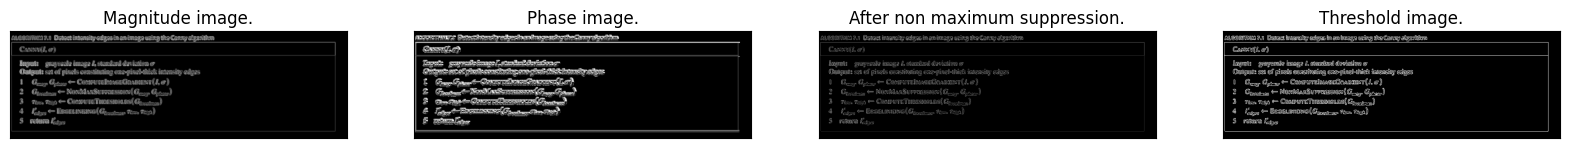

In [22]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt 

Im = cv2.imread("./images/images/canny.png", cv2.IMREAD_GRAYSCALE)

t_low = 100
t_high = 250
I_edges = my_cannyAlgorithm(Im, t_low, t_high)

**b)** Test your algorithm with a image of your choice and compare your results with the predefined function in opencv: 

```python
cv2.Canny(img, t_low, t_high, L2gradient=True)
``` 
[Documentation](https://docs.opencv.org/2.4/modules/imgproc/doc/feature_detection.html?highlight=canny#canny).

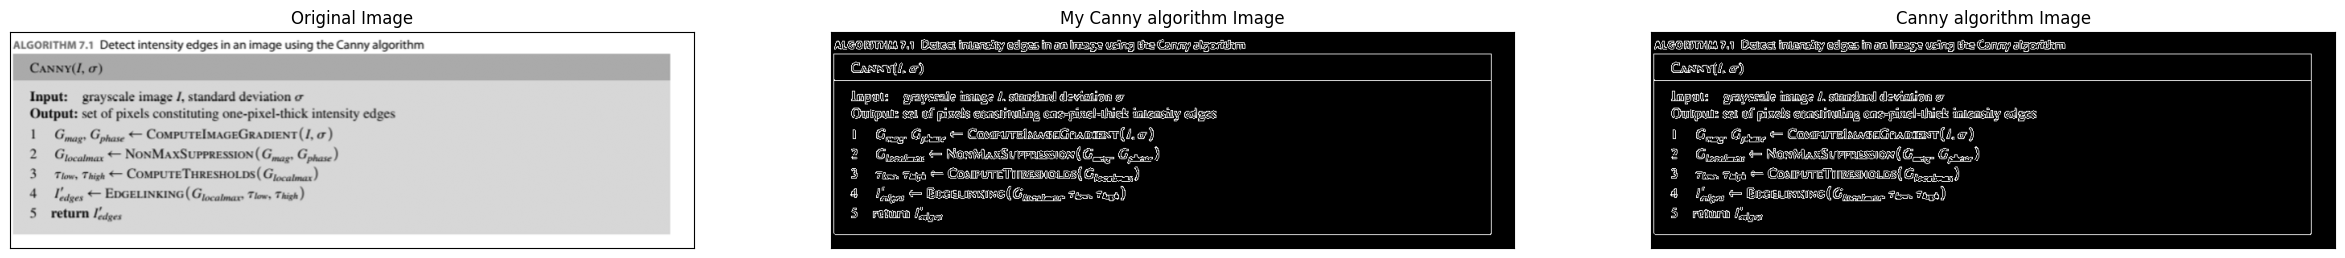

In [23]:
I_edges_cv = cv2.Canny(Im, t_low, t_high, apertureSize=3, L2gradient=True)
plt.figure(figsize=(30,10))
plt.subplot(131), plt.imshow(Im, cmap='gray'), plt.title('Original Image'), plt.xticks([]), plt.yticks([])
plt.subplot(132), plt.imshow(I_edges, cmap='gray'), plt.title('My Canny algorithm Image'), plt.xticks([]), plt.yticks([])
plt.subplot(133), plt.imshow(I_edges_cv, cmap='gray'), plt.title('Canny algorithm Image'), plt.xticks([]), plt.yticks([])
plt.show()

# Problem 2

One of the most popular approaches to feature detection is the **Harris corner detector**, after a work of Chris Harris and Mike Stephens from 1988.

**a)** Use the function in opencv `cv2.cornerHarris(...)` ([Documentation](https://docs.opencv.org/master/dd/d1a/group__imgproc__feature.html#gac1fc3598018010880e370e2f709b4345)) with `blockSize=2, ksize=3, k=0.04` with the **./images/chessboard.png** image to detect the corners (you can find the image on CANVAS). Plot the image with the detected corners found.

**Hint**: Use the function `cv2.drawMarker(...)` ([Documentation](https://docs.opencv.org/trunk/d6/d6e/group__imgproc__draw.html#ga644c4a170d4799a56b29f864ce984b7e)) to show the corners in the image.

In [24]:
def getCornersFromHarris(Im, blockSize, ksize, k, markerSize, thickness):
    # Convert the image from color to grayscale
    if len(Im.shape) > 2:
        gray_img = cv2.cvtColor(Im, cv2.COLOR_BGR2GRAY)
    else:
        gray_img = Im

    # Detect corners
    dst = cv2.cornerHarris(np.float32(gray_img), blockSize, ksize, k)

    # Normalize the corners between 0 and 255
    dst_norm = cv2.normalize(dst, None, 0, 255, cv2.NORM_MINMAX)

    # Threshold for an optimal value
    thres = 0.01 * dst.max()

    # Create a black background to draw the corners
    corners = np.zeros_like(Im)

    # Plot markers  
    for x in range(dst_norm.shape[0]):
        for y in range(dst_norm.shape[1]):
            if dst[x, y] > thres:
                # Draw red markers in the original image
                cv2.drawMarker(Im, (y, x), (0, 0, 255),
                               markerType=cv2.MARKER_TILTED_CROSS,
                               markerSize=markerSize, thickness=thickness)
                
                # Draw white markers in 'corners'
                cv2.drawMarker(corners, (y, x), (255, 255, 255),
                               markerType=cv2.MARKER_TILTED_CROSS,
                               markerSize=markerSize, thickness=thickness)
    
    return dst_norm, corners


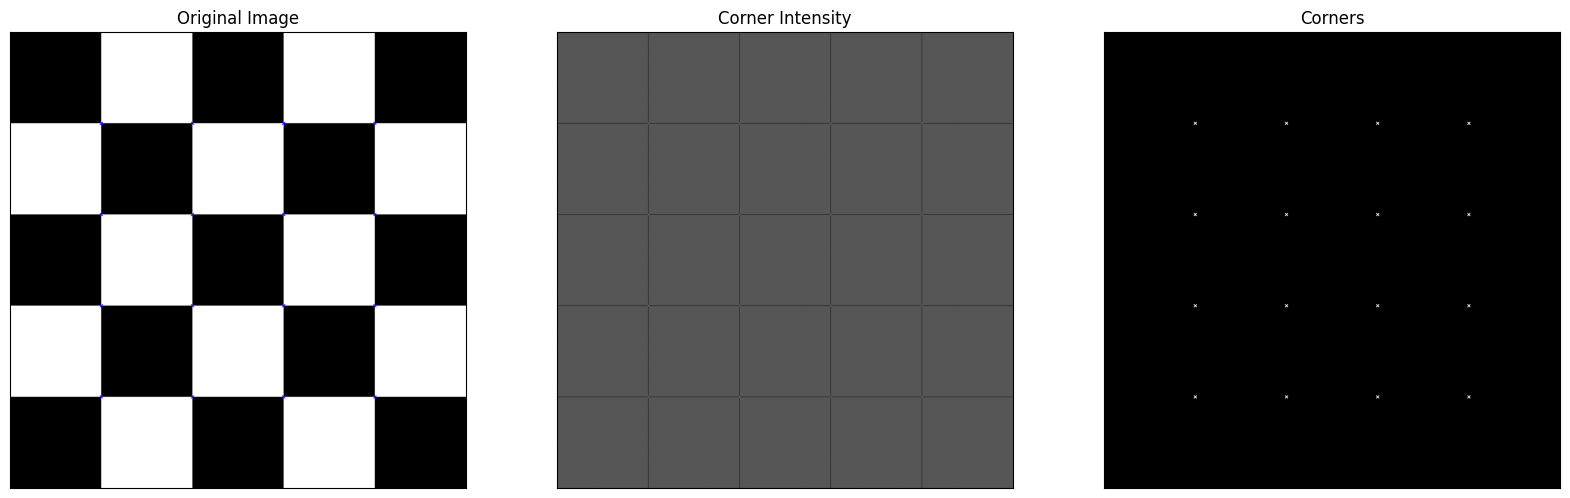

In [25]:
# Plot the results
Im = cv2.imread("./images/images/chessboard.png")

markerSize = 10
thickness = 10
dst_norm, corners = getCornersFromHarris(Im, 2, 3, 0.04, 10, 1)

plt.figure(figsize=(20,10))
plt.subplot(131), plt.imshow(Im), plt.title('Original Image'), plt.xticks([]), plt.yticks([])
plt.subplot(132), plt.imshow(dst_norm, cmap="gray", vmin=0, vmax=255), plt.title('Corner Intensity'), plt.xticks([]), plt.yticks([])
plt.subplot(133), plt.imshow(corners,cmap="gray", vmin=0, vmax=255), plt.title('Corners'), plt.xticks([]), plt.yticks([])
plt.show()

**b)** Detect the corners using the images **./images/arrow_1.jpg**, **./images/arrow_2.jpg** and **./images/arrow_3.jpg**; describe and compare the results in the three images.

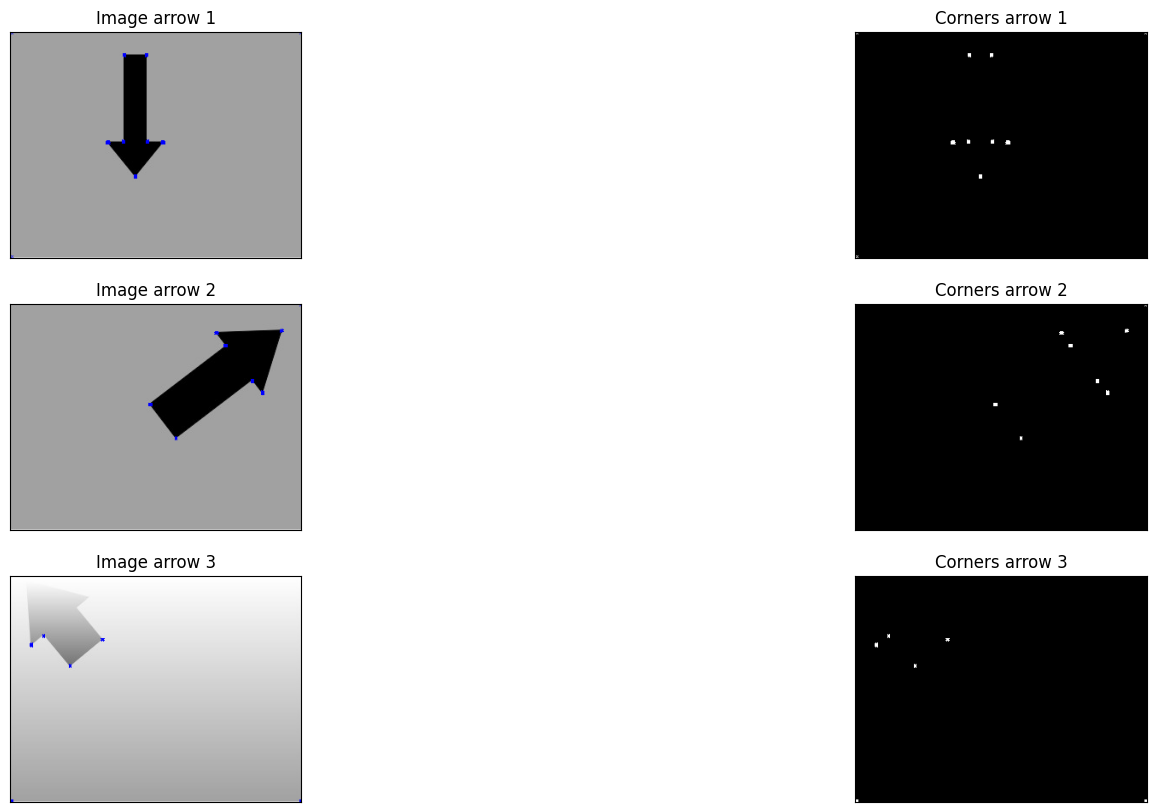

In [26]:
Im_1 = cv2.imread("./images/images/arrow_1.jpg")
Im_2 = cv2.imread("./images/images/arrow_2.jpg")
Im_3 = cv2.imread("./images/images/arrow_3.jpg")

markerSize = 2
thickness = 1

dst_norm_1, corners_1 = getCornersFromHarris(Im_1, 2, 3, 0.04, markerSize, thickness)
dst_norm_2, corners_2 = getCornersFromHarris(Im_2, 2, 3, 0.04, markerSize, thickness)
dst_norm_3, corners_3 = getCornersFromHarris(Im_3, 2, 3, 0.04, markerSize, thickness)

plt.figure(figsize=(20,10))
plt.subplot(321), plt.imshow(Im_1,cmap="gray"), plt.title('Image arrow 1'), plt.xticks([]), plt.yticks([])
plt.subplot(322), plt.imshow(corners_1,cmap="gray"), plt.title('Corners arrow 1'), plt.xticks([]), plt.yticks([])
plt.subplot(323), plt.imshow(Im_2,cmap="gray"), plt.title('Image arrow 2'), plt.xticks([]), plt.yticks([])
plt.subplot(324), plt.imshow(corners_2,cmap="gray"), plt.title('Corners arrow 2'), plt.xticks([]), plt.yticks([])
plt.subplot(325), plt.imshow(Im_3,cmap="gray"), plt.title('Image arrow 3'), plt.xticks([]), plt.yticks([])
plt.subplot(326), plt.imshow(corners_3,cmap="gray"), plt.title('Corners arrow 3'), plt.xticks([]), plt.yticks([])
plt.show()

# Problem 3 

**a)** What is the SIFT approach? Describe the steps involved.


Scale-Invariant Feature Transform is a feature detection and description algorithem. 

- step one: Scale-space construction
    - Blur the images more and more using gausian and then compare them using DoG
- step two: Keypoint localization
    - collecting local minima and maxima 
    - Low-contrast points and edge responses are removed
- step three: Orientation assignment
    - key points are assigned orientations
    - This ensures rotation invariance
- step four: Keypoint descriptor creation
- step five: Matching keypoints


**b)** Why this approach is more popular than the Harris detector?


- Detects features at multiple scales
- Fully rotation-invariant
- Object recognition, matching, tracking

**c)** Explain the difference between a feature detector and a feature descriptor.

- Feature Detector
    - Finds where keypoints are in the image.
- Feature Descriptor
    - Describes what the neighborhood around each keypoint looks like.

## Contact
### Course teacher
Professor Kjersti Engan, room E-431,
E-mail: kjersti.engan@uis.no

### Teaching assistant
Md Sazidur Rahman, room E-401
E-mail: md.s.rahman@uis.no


## References

[1] S. Birchfeld, Image Processing and Analysis. Cengage Learning, 2016.

[2] I. Austvoll, "Machine/robot vision part I," University of Stavanger, 2018. Compendium, CANVAS.